In [132]:
# import needed lib
import os
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import joblib

In [134]:
CUR_DIR = os.getcwd()

In [136]:
# read all the captcha 
def load_data(file_path):
    n_samples = len(os.listdir(file_path))
    imgs = []
    labels = []

    # read from the directory
    for i, img in enumerate(os.listdir(file_path)):
        if (i == 10):
            break;
        imgs.append(cv2.resize(cv2.imread(os.path.join(file_path, img), 0), (300, 57)))
        labels.append(img[0:-6])

    return np.array(imgs), labels

    # # print the ddtype
    # print(X[0].dtype) # uint8

    # # preprocess the image
    # for i in range(len(X)):
    #     X[i] = cv2.resize(X[i], (300, 57)) # reshape it to the same size
    #     X[i] = cv2.equalizeHist(X[i]) # increase the contrast of the img
    #     # X[i] = cv2.medianBlur(X[i], (2)) # try to remove noise term

In [138]:
def preprocess_data(imgs):
    processed_data = imgs
    return processed_data

In [146]:
from sklearn.model_selection import train_test_split
def split_data(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [270]:
from sklearn.preprocessing import LabelEncoder
# Encode labels as sequences of integers
def encode_labels(labels, max_timesteps):
    label_encoder = LabelEncoder()
    label_encoder.fit(list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"))  # All possible characters
    encoded_labels = [label_encoder.transform(list(label)) for label in labels]
    padded_labels = np.array([
        np.pad(l, (0, max_timesteps - len(l)), 
               mode='constant', constant_values=-1)
        for l in encoded_labels
    ])
    joblib.dump(label_encoder, 'label_encoder.pkl')  # Save to file
    return padded_labels, label_encoder

In [510]:
# CTC loss function
def ctc_loss(y_true, y_pred):
    # print('[DEBUG] start ctc_loss')
    # tf.config.run_functions_eagerly(True)  # Temporary debug

    # Get the batch size and sequence length
    batch_size = tf.shape(y_pred)[0]
    seq_length = tf.shape(y_pred)[1]
    
    # Calculate input length (same for all samples)
    input_length = tf.fill([batch_size], seq_length)  # [259, 259,...]
    
    # Calculate label length (count non-padded tokens)
    label_length = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)
    
    # Convert types for CTC
    y_true = tf.cast(y_true, tf.int32)
    input_length = tf.cast(input_length, tf.int32)
    label_length = tf.cast(label_length, tf.int32)

    # Reshape tensors for CTC
    y_true = tf.reshape(y_true, [batch_size, -1])  # Ensure 2D
    input_length = tf.reshape(input_length, [batch_size, 1])
    label_length = tf.reshape(label_length, [batch_size, 1])

    # print(f'[DEBUG] shape: y_true {y_true.shape}, y_pred: {y_pred.shape}')
    # print(f'[DEBUG] batch_size: {batch_size}, input_length: {input_length}, label_length: {label_length}')
            
    # Compute loss
    loss = keras.backend.ctc_batch_cost(
        y_true, y_pred,
        input_length=input_length,
        label_length=label_length
    )

    return loss

In [468]:
class CTCMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, encoder, batch_size=32):
        super().__init__()
        self.validation_data = validation_data
        self.encoder = encoder
        self.batch_size = batch_size
        
    def on_epoch_end(self, epoch, logs=None):
        # print('[DEBUG] start ctc metrics')
        x_val, y_val = self.validation_data
        total_samples = len(x_val)
        correct = 0

        # print(f"\n[DEBUG] y_val shape: {y_val.shape}, min/max: {y_val.min()}/{y_val.max()}")
            
        # Process in batches to avoid memory issues
        for i in range(0, total_samples, self.batch_size):
            batch_x = x_val[i:i+self.batch_size]
            batch_y = y_val[i:i+self.batch_size]
            
            # Predict
            y_pred = self.model.predict(batch_x, verbose=0)
            # print(f"[DEBUG] y_pred shape: {y_pred.shape}")
            
            # CTC decode
            input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
            decoded, _ = tf.keras.backend.ctc_decode(
                y_pred,
                input_length=input_length,
                greedy=True
            )
            pred_indices = decoded[0].numpy()
    

            
            # Compare predictions with ground truth
            for true_seq, pred_seq in zip(batch_y, pred_indices):
                # Remove padding (-1) and decode
                true_chars = true_seq[true_seq != -1]
                pred_chars = pred_seq[pred_seq != -1]
                
                # Convert to text
                true_text = ''.join(self.encoder.inverse_transform(true_chars))
                pred_text = ''.join(self.encoder.inverse_transform(pred_chars))
                
                if true_text == pred_text:
                    correct += 1
        
        accuracy = correct / total_samples
        print(f"[INFO] Validation Accuracy: {accuracy:.4f}")
        print(f"[INFO] True: '{true_text}' vs Pred: '{pred_text}'")
        logs['val_accuracy'] = accuracy  # Store for history

In [352]:
def train():
    # loading data
    imgs, labels = load_data("./data/train") # (10, 57, 300), (10)

    # # print the ddtype
    # print(imgs[0].dtype) # uint8
    
    # # print the original img
    # plt.figure(figsize=(8,8))
    # for i in range(len(imgs)):
    #     plt.subplot(5, 2, i+1)
    #     plt.imshow(imgs[i])
    #     plt.xlabel(f"{labels[i]}")
    # plt.show()

    # preprocess data
    processed_imgs = preprocess_data(imgs)

    # encode labels
    max_length = max(len(label) for label in labels)
    encoded_labels, encoder = encode_labels(labels, 259)
    # print(f'[DEBUG] shape: encoded_labels {encoded_labels.shape}')
    # print(f'[DEBUG] encoded_label: {encoded_labels[0]}')
    # unpadded = np.delete(encoded_labels[0], np.where(encoded_labels[0] == -1)[0])
    # print(f'[DEBUG] unpadded_label: {unpadded}')
    # decoded = encoder.inverse_transform(unpadded)
    # print(f'[DEBUG] decoded: {decoded} vs true: {labels[0]}')
    
    # Reshape images for CNN input
    processed_imgs_reshape = processed_imgs.reshape(-1, 57, 300, 1)  # (batch_size, height, width, channels)

    # Create the model
    input_shape = (57, 300, 1)  # Input image shape (height, width, channels)
    num_classes = len(encoder.classes_)  # Number of unique characters
    model = create_crnn_model(input_shape, num_classes, max_length)
    print(f'[DEBUG] Model output layer shape: {model.output_shape}')
    
    # Compile the model
    model.compile(optimizer='adam', loss=ctc_loss, metrics=['accuracy'])

    # Split the data
    X_train, X_val, y_train, y_val = split_data(processed_imgs, encoded_labels)

    # Reshape the data for training
    X_train = np.expand_dims(X_train, axis=-1)  # Shape becomes (8, 57, 300, 1)
    X_val = np.expand_dims(X_val, axis=-1)     # Shape becomes (2, 57, 300, 1)
    print(f'[DEBUG] shape: X_train: {X_train.shape}, X_val: {X_val.shape}')
    print(f'[DEBUG] shape: y_train: {y_train.shape}, y_val: {y_val.shape}')

    # Initialize with your actual data
    ctc_metrics = CTCMetrics(
        validation_data=(X_val, y_val),
        encoder=encoder,
        batch_size=32
    )
    
    # Train with the callback
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[ctc_metrics]
    )
    
    # Save the model
    model.save("captcha_crnn_model.keras")

In [226]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, LSTM, Dense, Lambda

# Define the CNN + RNN model
def create_crnn_model(input_shape, num_classes, max_length=6):
    # Input layer
    input_layer = Input(shape=input_shape)

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Dynamic reshape for RNN
    conv_shape = x.shape  # Get (batch, height, width, channels)
    print(f'[DEBUG] conv_shape: {conv_shape}')
    timesteps = conv_shape[1] * conv_shape[2]
    features = conv_shape[3]
    x = Reshape((timesteps, features))(x)

    # RNN layers
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Output layer
    output_layer = Dense(num_classes+1, activation='softmax')(x)  # +1 for CTC blank token

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [152]:
def load_model():
    # load keras model
    try:
        model_path = 'captcha_crnn_model.keras'  # or full path like 'models/your_model.keras'
        model = keras.models.load_model(model_path, 
                                        custom_objects={'ctc_loss': keras.backend.ctc_batch_cost})
        
        print("[INFO] Model loaded successfully!")
        print(f"[INFO] Model architecture:")
        model.summary()
        
    except FileNotFoundError:
        print(f"[ERROR] Error: File '{model_path}' not found. Check the path.")
    except Exception as e:
        print(f"[ERROR] Error loading model: {str(e)}")
        
    return model

def load_encoder():
    # load labal
    encoder = joblib.load('label_encoder.pkl')
    print('[INFO] Encoder loaded successfully!')
    return encoder

In [480]:
def decode_predictions(pred, encoder):
    pred_decoded, _ = keras.backend.ctc_decode(pred, input_length=[pred.shape[1]], greedy=True)
    pred_indices = pred_decoded[0].numpy()[0]
    valid_indices = pred_indices[pred_indices != -1]
    
    if len(valid_indices) == 0:
        return ""  # Return empty string if no valid predictions
    
    pred_chars = encoder.inverse_transform(valid_indices)
    return ''.join(pred_chars)

In [506]:
# Predict a CAPTCHA image
def predict_captcha(model, encoder, file_path):
    file_path = os.path.join(CUR_DIR, file_path)
    
    # print(f'[DEBUG] Current file path: {file_path}')
    
    n_samples = len(os.listdir(file_path))
    labels = []
    preds = []
    
    # print(f'[DEBUG] Number of samples: {n_samples}')

    # read from the directory
    for i, img in enumerate(os.listdir(file_path)):
        if (i == 1):
            break;
        img_read = cv2.resize(cv2.imread(os.path.join(file_path, img), 0), (300, 57))
        labels.append(img[0:-6])
        
        print('[DEBUG] Image sample and its label to be predict:')
        plt.figure(figsize=(8,8))
        plt.imshow(img_read)
        plt.title(f'{labels[0]}')
        plt.show()
        plt.close()  
    
        # # Preprocess the image
        img_reshaped = img_read.reshape(-1, 57, 300, 1)  # Reshape for model input
        print(f'[DEBUG] Image shape after preprocessing: {img_reshaped.shape}')
        
        # Predict the CAPTCHA
        print('[DEBUG] model prediction:')
        pred = model.predict(img_reshaped)
        final_text = decode_predictions(pred, encoder)
        preds.append(final_text)
        print(f'[DEBUG] prediction length: {len(final_text)}')
        print(f'[DEBUG] prediction: {final_text}')
    return labels, preds

In [518]:
a = np.array([1,2,3])
print(np.pad(a, (3,0), 'constant', constant_values=0))

[0 0 0 1 2 3]


In [158]:
def predict():
    # print(f'[DEBUG]{os.getcwd()}')
    model = load_model()
    encoder = load_encoder()
    labels, predicts = predict_captcha(model, encoder, "data/test")

[INFO] Model loaded successfully!
[INFO] Model architecture:


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 57, 300, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 57, 300, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 28, 150, 32)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 28, 150, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 14, 75, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 14, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 7, 37, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_48 (Reshape)            │ (None, 259, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_94 (LSTM)                  │ (None, 259, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 259, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 259, 63)        │         4,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,279 (3.18 MB)

 Trainable params: 277,759 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 555,520 (2.12 MB)

[INFO] Encoder loaded successfully!
[DEBUG] Testing
[32  1  5 32]
['W' '1' '5' 'W']
[DEBUG] Image sample and its label to be predict:


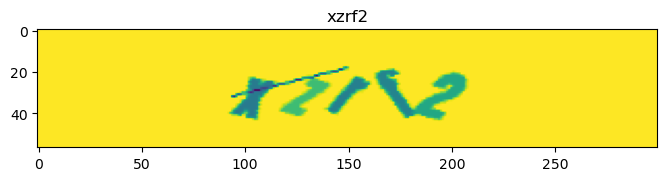

[DEBUG] Image shape after preprocessing: (1, 57, 300, 1)
[DEBUG] model prediction:


/opt/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[DEBUG] prediction length: 1
[DEBUG] prediction: 6


In [504]:
if __name__ == '__main__':
    # train()
    predict()